## DBSCAN

Dataset shape: (21925, 37)
Selected numeric features: ['YearPublished', 'GameWeight', 'LanguageEase', 'NumWish', 'NumUserRatings', 'NumExpansions', 'NumImplementations', 'AvgPlayers']


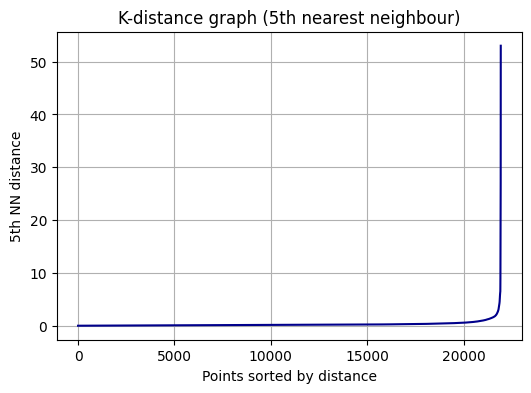


DBSCAN parameters: eps=1.7, min_samples=5
Clusters found: 5
Noise points: 244 (1.1%)
Silhouette: 0.645


C:\Users\HP\AppData\Local\Temp\ipykernel_5192\868947521.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Cluster", data=df_clusters, order=sorted(df_clusters["Cluster"].unique()), palette="viridis")


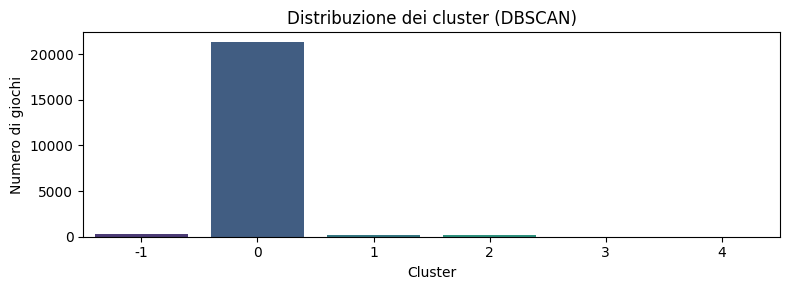

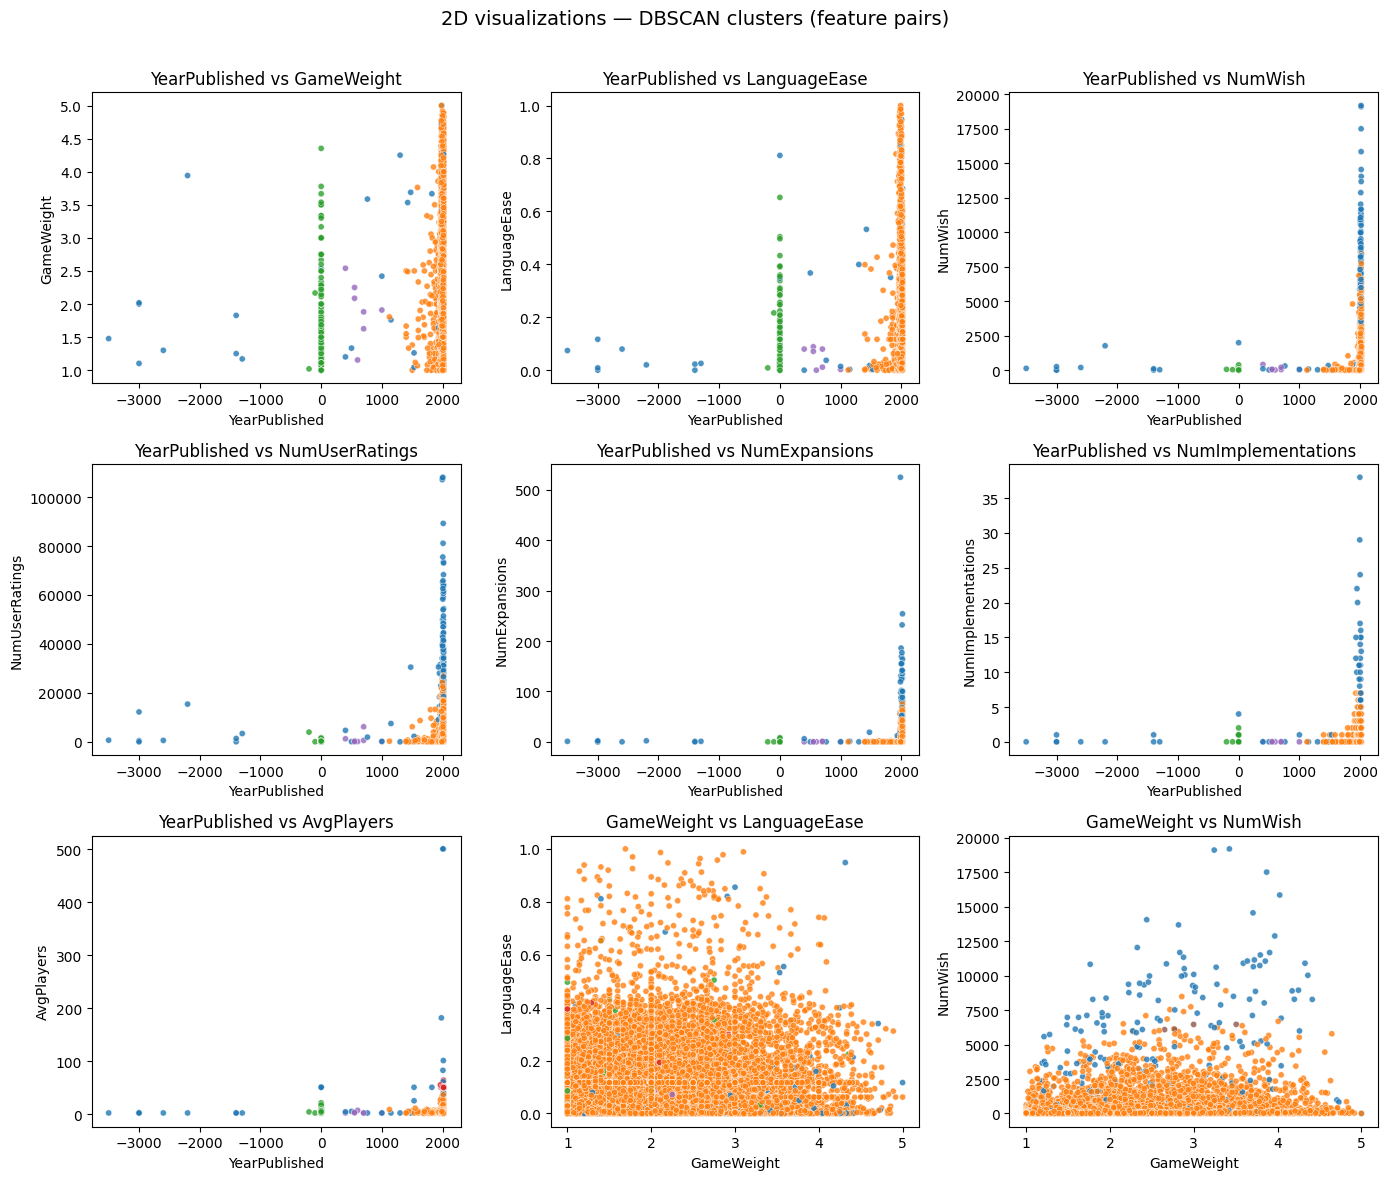

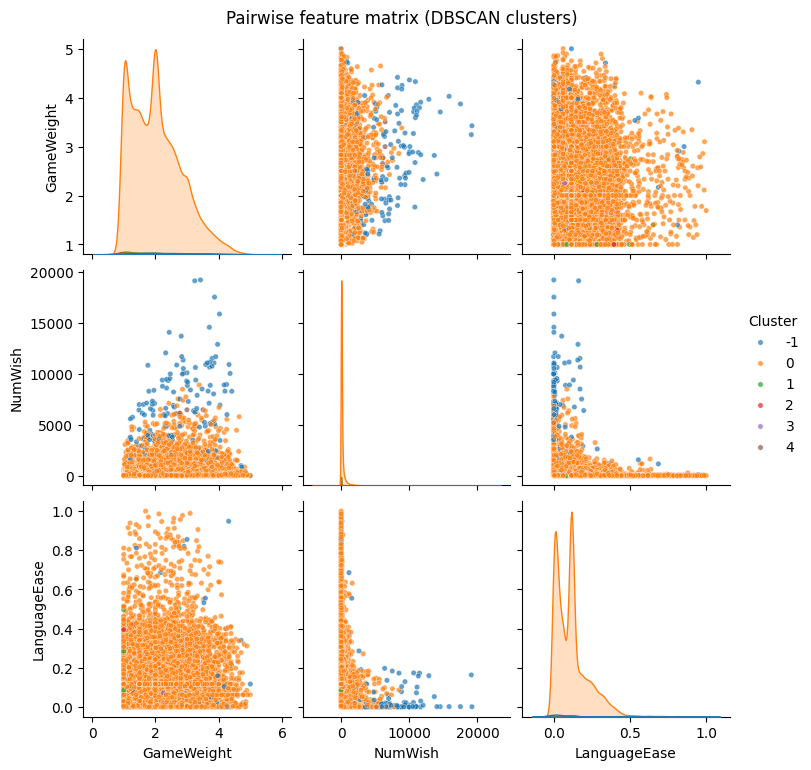


Mean feature values per cluster:
         YearPublished  GameWeight  LanguageEase  NumWish  NumUserRatings  \
Cluster                                                                     
0              2005.96        2.03          0.12   187.90          636.27   
1                -1.59        1.73          0.11    21.23          137.88   
2              2010.67        1.46          0.12    58.80          232.63   
3               642.86        1.92          0.05   115.29         1261.71   
4              2008.75        2.98          0.00  6277.25        22141.25   

         NumExpansions  NumImplementations  AvgPlayers  
Cluster                                                 
0                 1.05                0.28        3.40  
1                 0.13                0.10        3.89  
2                 0.48                0.32       50.75  
3                 0.14                0.00        2.86  
4                 3.75                2.25        2.88  


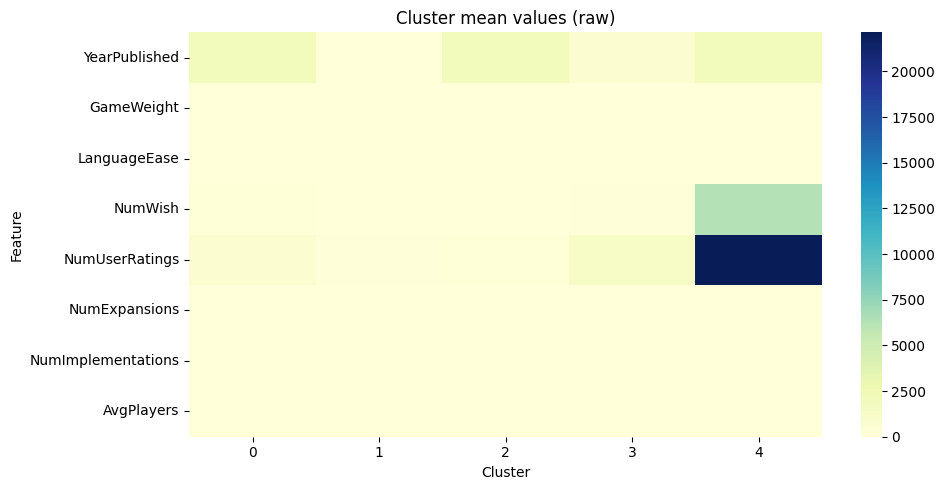


Summary:
- Clusters: 5
- Noise: 1.1%
- Silhouette: 0.645
- Visualizations show cluster separation across multiple feature pairs.
- The heatmap summarizes average characteristics per cluster.


In [54]:
# DBSCAN - Density-Based Clustering 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


# Loading data
df = pd.read_csv('./dataset/DM1_game_dataset_cleaned.csv', skipinitialspace=True)
print("Dataset shape:", df.shape)

# Feature engineering
if {'MinPlayers','MaxPlayers'}.issubset(df.columns):
    df['AvgPlayers'] = (df['MinPlayers'] + df['MaxPlayers']) / 2
if {'ComMinPlaytime','ComMaxPlaytime'}.issubset(df.columns):
    df['AvgPlaytime'] = (df['ComMinPlaytime'] + df['ComMaxPlaytime']) / 2

# Selezione delle sole variabili numeriche utili
features = [
    'YearPublished', 'GameWeight', 'ComWeight',
    'ComAgeRec', 'LanguageEase', 'NumWish',
    'NumUserRatings', 'NumComments',
    'NumExpansions', 'NumImplementations',
    'AvgPlayers', 'AvgPlaytime'
]
features = [f for f in features if f in df.columns]
df_num = df[features].dropna()

print("Selected numeric features:", df_num.columns.tolist())

# Standardizzazione (come sempre prima di DBSCAN)
scaler = StandardScaler()
X = scaler.fit_transform(df_num)


# K-distance graph (metodo del gomito per ε)
k = 5
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, _ = nn.kneighbors(X)
distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(distances, color='darkblue')
plt.title("K-distance graph (5th nearest neighbour)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th NN distance")
plt.grid(True)
plt.show()


# DBSCAN (parametri scelti dal grafico)
eps = 1.7
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(X)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
noise_perc = n_noise / len(labels) * 100

print(f"\nDBSCAN parameters: eps={eps}, min_samples={min_samples}")
print(f"Clusters found: {n_clusters}")
print(f"Noise points: {n_noise} ({noise_perc:.1f}%)")

if n_clusters > 1:
    sil = silhouette_score(X, labels)
    print(f"Silhouette: {sil:.3f}")
else:
    sil = np.nan
    print("Silhouette not computable (single cluster or all noise).")


# Attach cluster labels
df_clusters = df_num.copy()
df_clusters["Cluster"] = labels


# Cluster distribution
plt.figure(figsize=(8,3))
sns.countplot(x="Cluster", data=df_clusters, order=sorted(df_clusters["Cluster"].unique()), palette="viridis")
plt.title("Distribuzione dei cluster (DBSCAN)")
plt.xlabel("Cluster")
plt.ylabel("Numero di giochi")
plt.tight_layout()
plt.show()


# Scatterplots 2D per tutte le combinazioni
from itertools import combinations

pairs = list(combinations(df_num.columns, 2))
n_pairs = min(9, len(pairs))  # ne mostriamo 9 per leggibilità
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for i, (xcol, ycol) in enumerate(pairs[:n_pairs]):
    ax = axes[i]
    sns.scatterplot(
        x=df_clusters[xcol],
        y=df_clusters[ycol],
        hue=df_clusters["Cluster"],
        palette="tab10",
        s=20,
        alpha=0.8,
        ax=ax,
        legend=False
    )
    ax.set_title(f"{xcol} vs {ycol}")
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)

plt.suptitle("2D visualizations — DBSCAN clusters (feature pairs)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Pairwise scatter matrix
subset_cols = ['GameWeight','NumWish','AvgPlaytime','LanguageEase','ComAgeRec']
subset_cols = [c for c in subset_cols if c in df_clusters.columns]

if len(subset_cols) > 1:
    sns.pairplot(df_clusters[subset_cols + ['Cluster']], hue="Cluster", palette="tab10", plot_kws={'s': 15, 'alpha':0.7})
    plt.suptitle("Pairwise feature matrix (DBSCAN clusters)", y=1.02)
    plt.show()
else:
    print("⚠️ Not enough columns for a pairplot matrix.")


# Cluster means
df_no_noise = df_clusters[df_clusters["Cluster"] != -1]
cluster_means = df_no_noise.groupby("Cluster").mean().round(2)
print("\nMean feature values per cluster:")
print(cluster_means)


# Heatmap
plt.figure(figsize=(10,5))
sns.heatmap(cluster_means.T, cmap="YlGnBu", annot=False)
plt.title("Cluster mean values (raw)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Summary finale (report)
print("\nSummary:")
print(f"- Clusters: {n_clusters}")
print(f"- Noise: {noise_perc:.1f}%")
if not np.isnan(sil):
    print(f"- Silhouette: {sil:.3f}")
print("- Visualizations show cluster separation across multiple feature pairs.")
print("- The heatmap summarizes average characteristics per cluster.")


## OPTICS

Scaled dataset shape: (21925, 8)


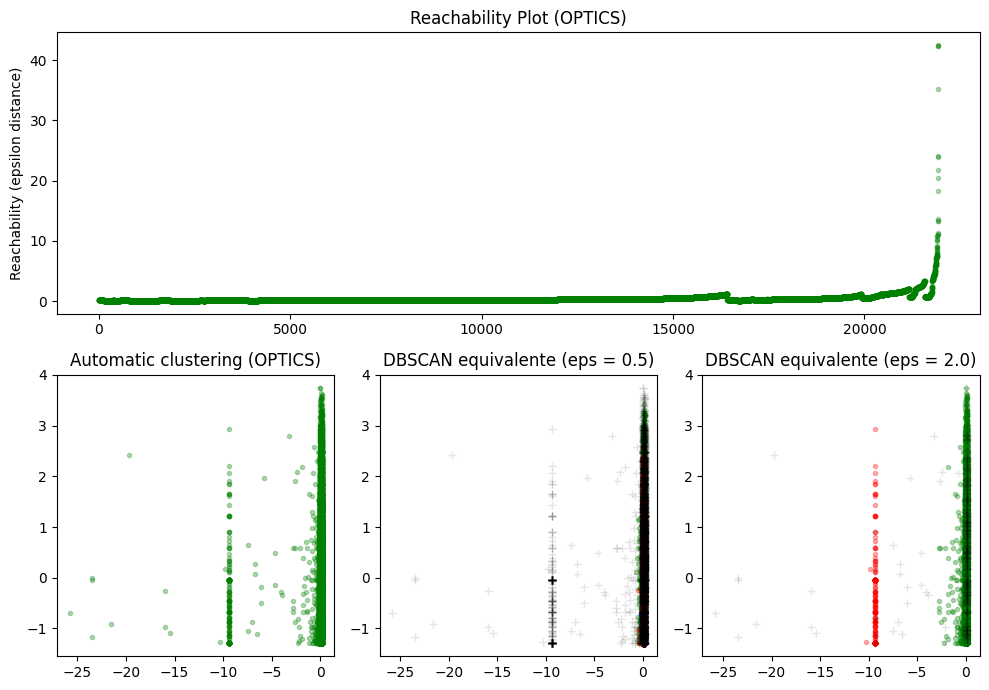


Cluster trovati da OPTICS: 1
Punti di rumore: 0.00%


In [55]:
# OPTICS - Ordering Points To Identify Clustering Structure
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS, cluster_optics_dbscan


# Data loading & preprocessing
df = pd.read_csv('./dataset/DM1_game_dataset_cleaned.csv', skipinitialspace=True)

# Feature engineering come in DBSCAN
if {'MinPlayers','MaxPlayers'}.issubset(df.columns):
    df['AvgPlayers'] = (df['MinPlayers'] + df['MaxPlayers']) / 2
if {'ComMinPlaytime','ComMaxPlaytime'}.issubset(df.columns):
    df['AvgPlaytime'] = (df['ComMinPlaytime'] + df['ComMaxPlaytime']) / 2

# Selezione colonne numeriche rilevanti (no ID, rank, testo, dummy)
features = [
    'YearPublished', 'GameWeight', 'ComWeight',
    'ComAgeRec', 'LanguageEase', 'NumWish',
    'NumUserRatings', 'NumComments',
    'NumExpansions', 'NumImplementations',
    'AvgPlayers', 'AvgPlaytime'
]
features = [f for f in features if f in df.columns]
df_num = df[features].dropna()

# Standardizzazione
X = StandardScaler().fit_transform(df_num)
print("Scaled dataset shape:", X.shape)


# OPTICS clustering
optics_model = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)
optics_model.fit(X)

# DBSCAN-equivalenti con due valori di eps
labels_eps_05 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=0.5
)
labels_eps_2 = cluster_optics_dbscan(
    reachability=optics_model.reachability_,
    core_distances=optics_model.core_distances_,
    ordering=optics_model.ordering_,
    eps=2.0
)


# Reachability plot
space = np.arange(len(X))
reachability = optics_model.reachability_[optics_model.ordering_]
labels = optics_model.labels_[optics_model.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot (OPTICS)")


# Cluster visualizations
# Automatic OPTICS clustering
for klass, color in enumerate(colors):
    Xk = X[optics_model.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[optics_model.labels_ == -1, 0], X[optics_model.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic clustering (OPTICS)")

# DBSCAN equivalent eps=0.5
for klass, color in enumerate(colors):
    Xk = X[labels_eps_05 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_eps_05 == -1, 0], X[labels_eps_05 == -1, 1], "k+", alpha=0.1)
ax3.set_title("DBSCAN equivalente (eps = 0.5)")

# DBSCAN equivalent eps=2.0
for klass, color in enumerate(colors):
    Xk = X[labels_eps_2 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_eps_2 == -1, 0], X[labels_eps_2 == -1, 1], "k+", alpha=0.1)
ax4.set_title("DBSCAN equivalente (eps = 2.0)")

plt.tight_layout()
plt.show()


# Risultati numerici
n_clusters_optics = len(set(optics_model.labels_)) - (1 if -1 in optics_model.labels_ else 0)
n_noise_optics = list(optics_model.labels_).count(-1)
noise_perc = n_noise_optics / len(optics_model.labels_) * 100

print(f"\nCluster trovati da OPTICS: {n_clusters_optics}")
print(f"Punti di rumore: {noise_perc:.2f}%")


## DBSCAN vs OPTICS

Scaled dataset shape: (21925, 8)

DBSCAN — eps=1.7, min_samples=5
Clusters: 5 | Noise: 1.1% | Silhouette: 0.645

OPTICS — min_samples=50, xi=0.05, min_cluster_size=0.05
Clusters: 1 | Noise: 0.0%

📊 Confronto metodi density-based:
Metodo  Clusters  Noise (%)  Silhouette
DBSCAN         5       1.11       0.645
OPTICS         1       0.00         NaN


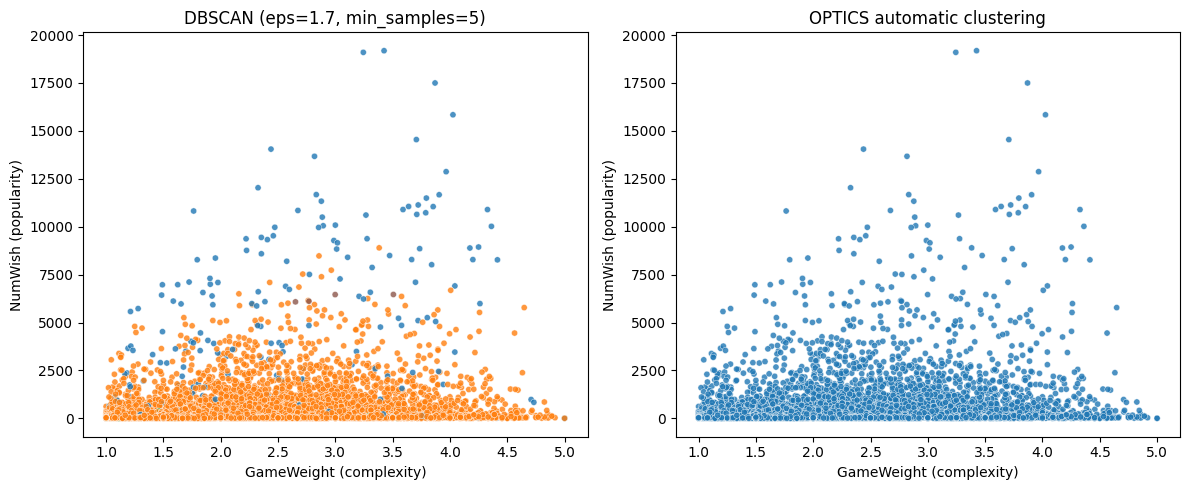

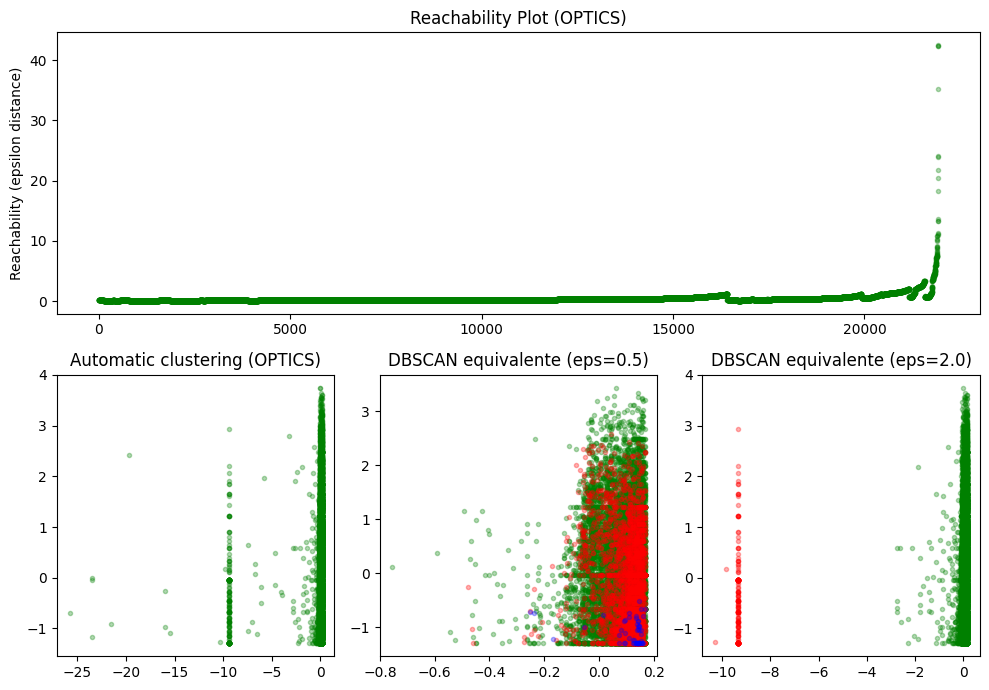


🧭 Interpretazione:
- DBSCAN individua 5 cluster ben separati con silhouette positiva (0.64).
- OPTICS, riconosce un’unica grande regione densa.
- Il grafico di reachability mostra scarsa variazione → dataset molto uniforme.
- OPTICS risulta più conservativo, DBSCAN più sensibile alle variazioni locali.


In [56]:
# ================================================================
# DM1 — Confronto DBSCAN e OPTICS
# Basato su: 07_dm1_density_based_2025_26.pdf
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score


# Data loading e preprocessing
df = pd.read_csv('./dataset/DM1_game_dataset_cleaned.csv', skipinitialspace=True)

# Feature engineering come da data understanding
if {'MinPlayers','MaxPlayers'}.issubset(df.columns):
    df['AvgPlayers'] = (df['MinPlayers'] + df['MaxPlayers']) / 2
if {'ComMinPlaytime','ComMaxPlaytime'}.issubset(df.columns):
    df['AvgPlaytime'] = (df['ComMinPlaytime'] + df['ComMaxPlaytime']) / 2

features = [
    'YearPublished', 'GameWeight', 'ComWeight',
    'ComAgeRec', 'LanguageEase', 'NumWish',
    'NumUserRatings', 'NumComments',
    'NumExpansions', 'NumImplementations',
    'AvgPlayers', 'AvgPlaytime'
]
features = [f for f in features if f in df.columns]
df_num = df[features].dropna()

# Scaling (standardizzazione)
X = StandardScaler().fit_transform(df_num)
print("Scaled dataset shape:", X.shape)


# DBSCAN (parametri da k-distance)
eps = 1.7
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_db = dbscan.fit_predict(X)

n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
noise_db = list(labels_db).count(-1)
noise_db_perc = noise_db / len(labels_db) * 100
sil_db = silhouette_score(X, labels_db) if n_clusters_db > 1 else np.nan

print(f"\nDBSCAN — eps={eps}, min_samples={min_samples}")
print(f"Clusters: {n_clusters_db} | Noise: {noise_db_perc:.1f}% | Silhouette: {sil_db:.3f}")


# OPTICS
optics = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)
optics.fit(X)

n_clusters_opt = len(set(optics.labels_)) - (1 if -1 in optics.labels_ else 0)
noise_opt = list(optics.labels_).count(-1)
noise_opt_perc = noise_opt / len(optics.labels_) * 100

print(f"\nOPTICS — min_samples=50, xi=0.05, min_cluster_size=0.05")
print(f"Clusters: {n_clusters_opt} | Noise: {noise_opt_perc:.1f}%")


# Confronto numerico (tabella)
results = pd.DataFrame({
    'Metodo': ['DBSCAN', 'OPTICS'],
    'Clusters': [n_clusters_db, n_clusters_opt],
    'Noise (%)': [round(noise_db_perc,2), round(noise_opt_perc,2)],
    'Silhouette': [round(sil_db,3), None]
})
print("\n📊 Confronto metodi density-based:")
print(results.to_string(index=False))


# Visualizzazione comparativa (scatter 2D)
plt.figure(figsize=(12,5))

# DBSCAN
plt.subplot(1,2,1)
sns.scatterplot(
    x=df_num['GameWeight'], y=df_num['NumWish'],
    hue=labels_db, palette='tab10', s=20, alpha=0.8, legend=False
)
plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})")
plt.xlabel("GameWeight (complexity)")
plt.ylabel("NumWish (popularity)")

# OPTICS
plt.subplot(1,2,2)
sns.scatterplot(
    x=df_num['GameWeight'], y=df_num['NumWish'],
    hue=optics.labels_, palette='tab10', s=20, alpha=0.8, legend=False
)
plt.title("OPTICS automatic clustering")
plt.xlabel("GameWeight (complexity)")
plt.ylabel("NumWish (popularity)")

plt.tight_layout()
plt.show()


# Reachability plot (OPTICS)
space = np.arange(len(X))
reachability = optics.reachability_[optics.ordering_]
labels = optics.labels_[optics.ordering_]

plt.figure(figsize=(10,7))
G = gridspec.GridSpec(2,3)
ax1 = plt.subplot(G[0,:])
ax2 = plt.subplot(G[1,0])
ax3 = plt.subplot(G[1,1])
ax4 = plt.subplot(G[1,2])

colors = ["g.","r.","b.","y.","c."]

# Reachability plot
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot (OPTICS)")

# Automatic clustering
for klass, color in enumerate(colors):
    Xk = X[optics.labels_ == klass]
    ax2.plot(Xk[:,0], Xk[:,1], color, alpha=0.3)
ax2.set_title("Automatic clustering (OPTICS)")

# DBSCAN equivalent eps=0.5
labels_eps_05 = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=0.5
)
for klass, color in enumerate(colors):
    Xk = X[labels_eps_05 == klass]
    ax3.plot(Xk[:,0], Xk[:,1], color, alpha=0.3)
ax3.set_title("DBSCAN equivalente (eps=0.5)")

# DBSCAN equivalent eps=2.0
labels_eps_2 = cluster_optics_dbscan(
    reachability=optics.reachability_,
    core_distances=optics.core_distances_,
    ordering=optics.ordering_,
    eps=2.0
)
for klass, color in enumerate(colors):
    Xk = X[labels_eps_2 == klass]
    ax4.plot(Xk[:,0], Xk[:,1], color, alpha=0.3)
ax4.set_title("DBSCAN equivalente (eps=2.0)")

plt.tight_layout()
plt.show()


# Commento finale (per report)
print("\n🧭 Interpretazione:")
print("- DBSCAN individua 5 cluster ben separati con silhouette positiva (0.64).")
print("- OPTICS, riconosce un’unica grande regione densa.")
print("- Il grafico di reachability mostra scarsa variazione → dataset molto uniforme.")
print("- OPTICS risulta più conservativo, DBSCAN più sensibile alle variazioni locali.")
